# pyBumpHunter2D Example

Simple notebook for testing the BumpHunter2D class.

We will use 2D histograms ranging between 0 and 25 (both axis) with $20 \times 20$ even bins.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyBumpHunter as BH
from datetime import datetime  ## Used to compute the execution time

## Generate the data

The data (generated with numpy) consists of three histograms: a steeply falling 'background' distribution, a 'signal' 2D gaussian shape centered on a value of [6.0,7.0], and a 'data' distribution sampled from background and signal distributions, with a signal fraction of 0.5%.

In [2]:
# Generate the background
np.random.seed(42)
bkg = np.random.exponential(scale=[4,4],size=(100000,2))

# Generate the data
Nsig = 500
data = np.empty(shape=(100000+Nsig,2))
data[:100000] = np.random.exponential(scale=[4,4],size=(100000,2))
data[100000:] = np.random.multivariate_normal(mean=[6.,7.],cov=[[3,0.5],[0.5,3]],size=(Nsig))

# Generate the signal
sig = np.random.multivariate_normal(mean=[6.,7.],cov=[[3,0.5],[0.5,3]],size=(10000))

# Expected position of the bump in the data
Lth = [6.,7.]

# Range of the histograms (used in the scans)
rang = [[0,25],[0,25]]

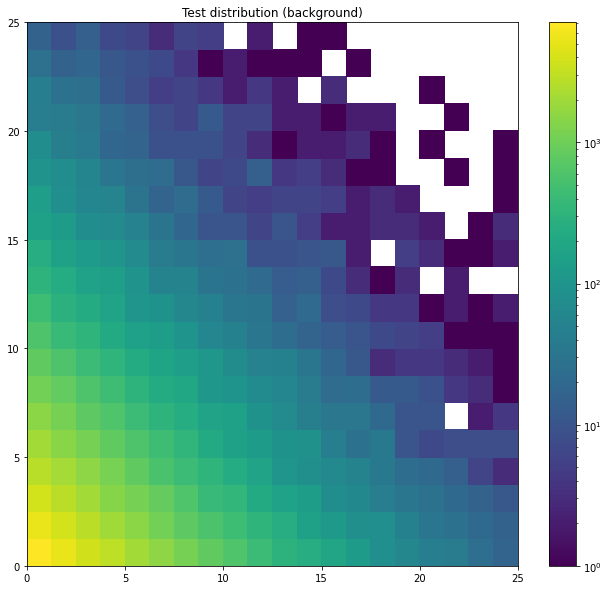

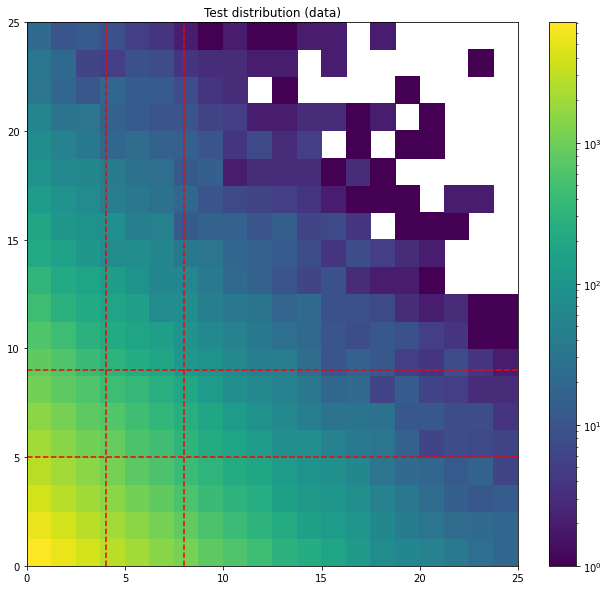

In [3]:
# Plot the 2 distributions (data and background) as 2D histograms
F = plt.figure(figsize=(11,10))
plt.title('Test distribution (background)')
_,binx,biny,_ = plt.hist2d(bkg[:,0],bkg[:,1],bins=[20,20],range=rang,norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

# The red dashed lines show the true posision of the signal
F = plt.figure(figsize=(11,10))
plt.title('Test distribution (data)')
plt.hist2d(data[:,0],data[:,1],bins=[20,20],range=rang,norm=matplotlib.colors.LogNorm())
plt.hlines([5.0,9.0],binx[0],binx[-1],linestyles='dashed',color='r')
plt.vlines([4.0,8.0],biny[0],biny[-1],linestyles='dashed',color='r')
plt.colorbar()
plt.show()

## Create a BumpHunter2D class instance.

The BumpHunter2D class provides all the methods required extend the bump hunt to 2D distributions.

All the parameters and results are also stored in this object.

In [4]:
# Create a BumpHunter class instance
hunter = BH.BumpHunter2D(
    rang=rang,
    width_min=[2, 2],
    width_max=[3, 3],
    width_step=[1, 1],
    scan_step=[1, 1],
    bins=[20, 20],
    npe=8000,
    nworker=1,
    seed=666,
)

## Call the bump_scan Method

The function will scan the data distribution using variable-width window sizes (between width_min and width_max) and calculate the p-value of data with respect to the background for each window. The minimum p-value obtained from all windows is the local p-value.

To cope with the look-elsewhere effect a global p-value is calculated using a two-step procedure:
- the distribution of possible p-values is determined from background-only pseudo-experiments (npe parameter)
- the p-value found in data is compared to the background-only p-value distribution to calculate the global p-value

In [5]:
print('####bump_scan call####')
begin = datetime.now()
hunter.bump_scan(data,bkg)
end = datetime.now()
print('time={}'.format(end-begin))

####bump_scan call####
Generating histograms
4 values of width will be tested
SCAN
Global p-value : 0.0000  (0 / 8000)
Significance = 7.94144

time=0:01:38.685054


## Print results of BH scan

Print information on more significant window ("bump"): location, width, excess over background events, global p-value and global significance.

In [6]:
hunter.print_bump_info()
hunter.print_bump_true(data,bkg)
print(f"   mean (true) = {Lth}")

BUMP WINDOW
   loc = [4, 5]
   width = [2, 2]
   local p-value | t = 0.00000 | 17.99286

BUMP POSITION
   min : [5.000, 6.250]
   max : [7.500, 8.750]
   mean : [6.250, 7.500]
   width : [2.500, 2.500]
   number of signal events : 201.0
   global p-value : 0.00000
   significance = 7.94144

   mean (true) = [6.0, 7.0]


## Show most significant window

Window with the lowest p-value obtained from the data scans.

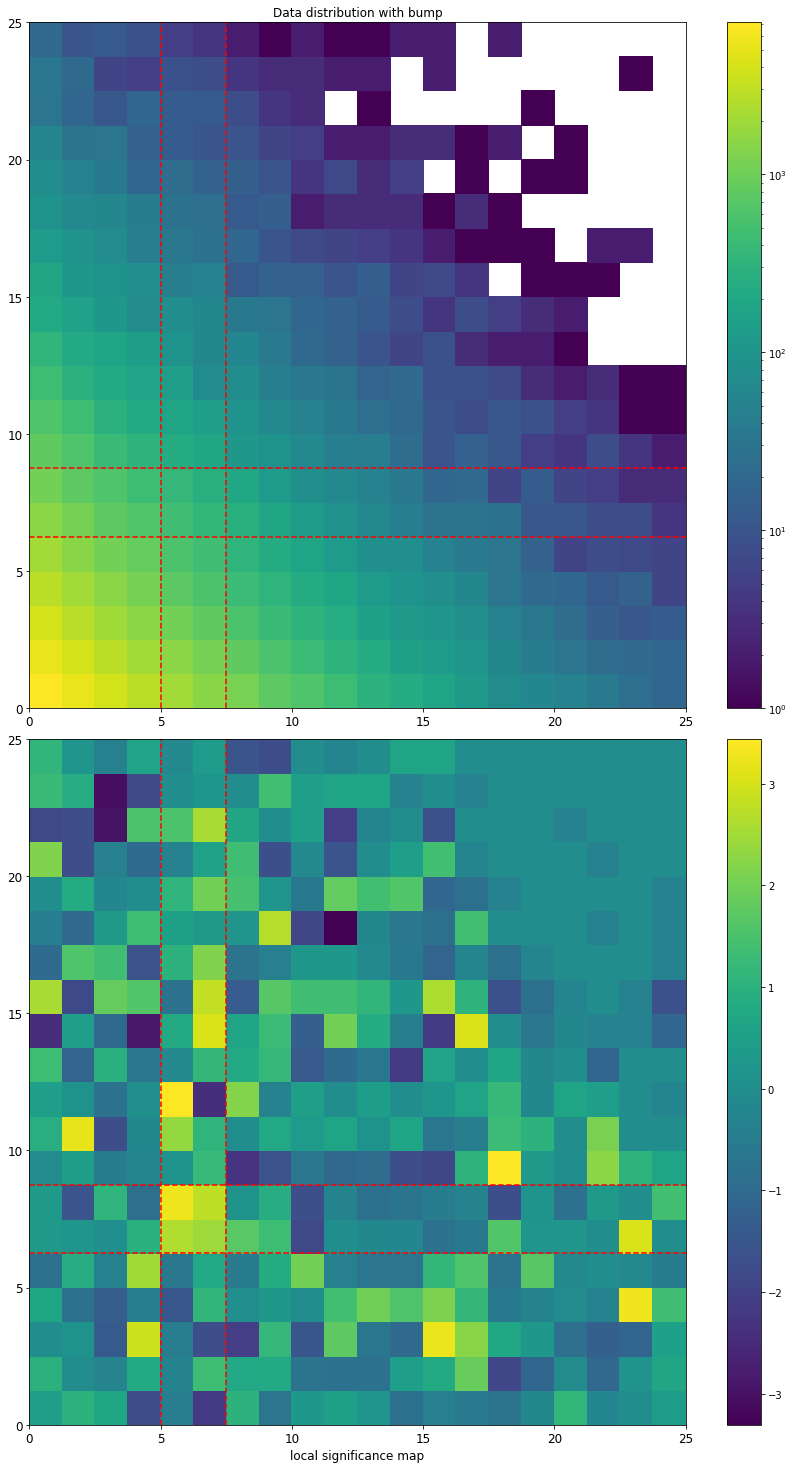

In [7]:
hunter.plot_bump(data,bkg)

# Global p-value

This figure shows the test statistics (log(p-value)) obtained from background-only toys and the p-value obtained from data. The global p-value is equal to the fraction of background-only experiments whch have a higher test statistics than for the data (i.e this is the p-value of p-values).

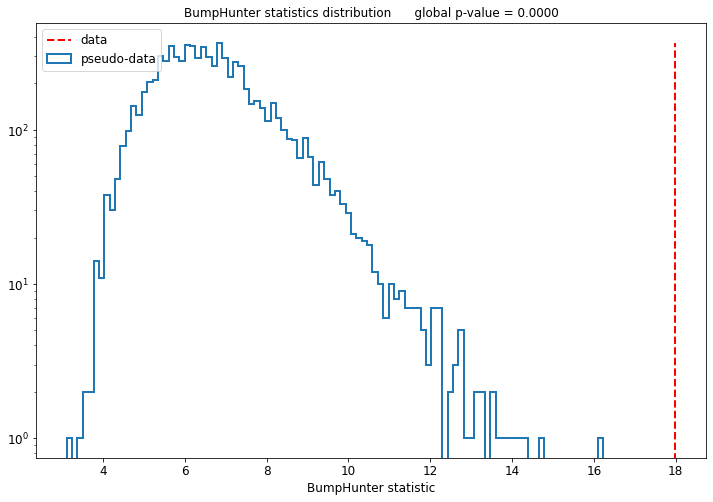

In [8]:
hunter.plot_stat(show_Pval=True)

## Signal injection  (Not implemented yet)

Inject signal in data until a 5 sigma excess is found. 